# Images consumption and EDA

In [53]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [33]:
full_path = 'gs://msca-ml-final-project/data/icml_face_data.csv'

In [34]:
full_df = pd.read_csv(full_path)

In [35]:
full_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### EDA

In [54]:
def plot_count_with_labels(data, column):
    """
    Creates a countplot with count labels on top of each bar.

    Args:
        data (DataFrame): The input DataFrame.
        column (str): The column name for which to create the countplot.

    Returns:
        None
    """
    sns.set(style="darkgrid")  # Set the style of the plot
    
    # Create the countplot
    ax = sns.countplot(x=column, data=data, order=data[column].value_counts().index)
    
    # Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    # Set x-tick labels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

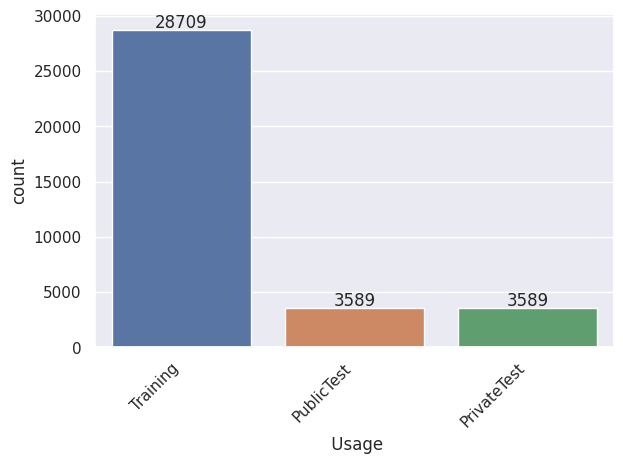

In [55]:
plot_count_with_labels(full_df, ' Usage')

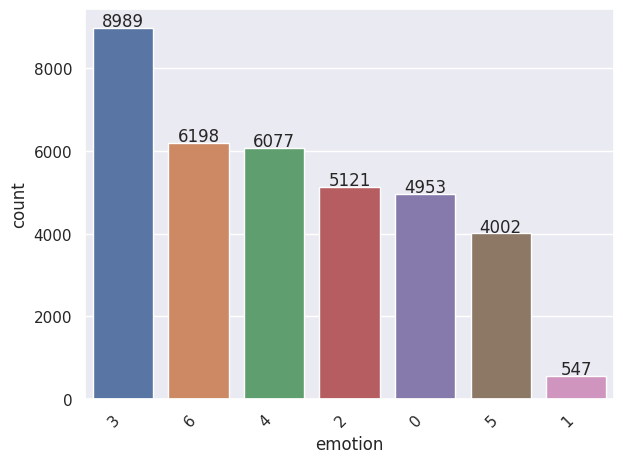

In [56]:
plot_count_with_labels(full_df, 'emotion')

## Feature engineering

In [57]:
# dictionary definition of emotion mapping
emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# create the 'emotion_class' column by mapping the 'emotion' column
full_df['emotion_class'] = full_df['emotion'].map(emotion_mapping)

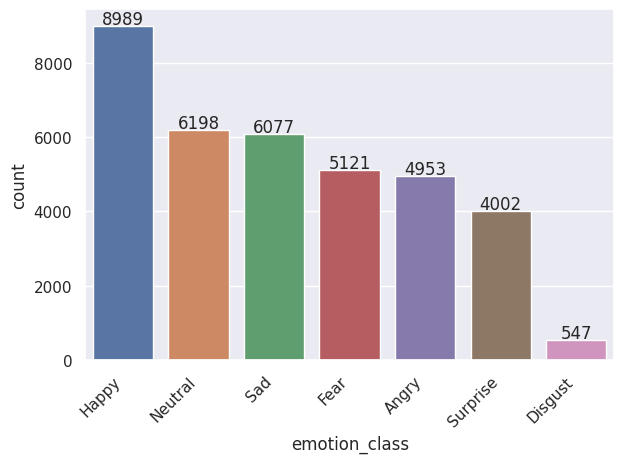

In [58]:
plot_count_with_labels(full_df, 'emotion_class')

## Image data preparation

In [61]:
from tensorflow.keras.utils import to_categorical

def preprocess_data(df):
    """
    Preprocesses the input data to train a neural network model.

    Args:
        train_df (DataFrame): Training DataFrame with 'emotion' and 'pixels' columns.

    Returns:
        tuple: A tuple containing the preprocessed training images and labels.
    """
    # Preprocess the input data
    input_shape = (48, 48, 1)  # Shape of input images
    num_classes = 7  # Number of classes for classification

    # Convert pixel values to numpy array and reshape them to images
    imgs = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in df[' pixels']])
    imgs = imgs.reshape(-1, 48, 48, 1)

    # Normalize the pixel values between 0 and 1
    imgs = imgs / 255.0

    # Convert the target labels to categorical format
    lbls = to_categorical(df['emotion'], num_classes)

    return imgs, lbls

Preprocess training

In [62]:
train_imgs, train_lbls = preprocess_data(full_df[full_df[" Usage"] == "Training"])
val_imgs, val_lbls = preprocess_data(full_df[full_df[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = preprocess_data(full_df[full_df[" Usage"] == "PublicTest"])

In [65]:
print(f'Shape of training data: {np.shape(train_imgs)}')
print(f'Shape of testing data: {np.shape(test_imgs)}')
print(f'Shape of validation data: {np.shape(val_imgs)}')

Shape of training data: (28709, 48, 48, 1)
Shape of testing data: (3589, 48, 48, 1)
Shape of validation data: (3589, 48, 48, 1)


## Visualizing some of the images

In [22]:
import matplotlib.pyplot as plt

def show_image(image):
    """
    Displays a single image in a Jupyter Notebook.

    Args:
        image (ndarray): NumPy array of the image to be displayed.
    """
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

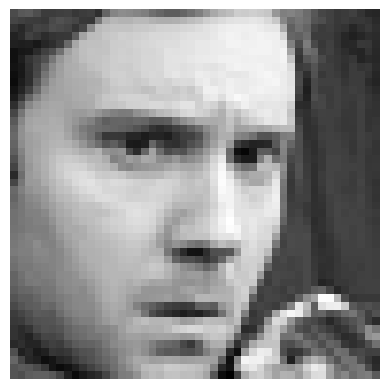

In [64]:
show_image(train_imgs[0])

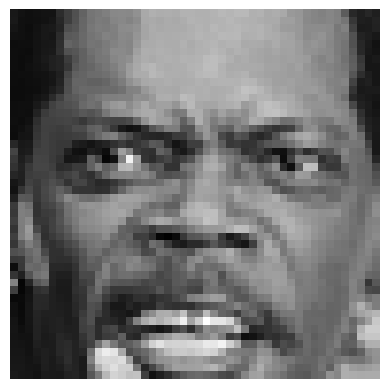

In [24]:
show_image(train_imgs[10])

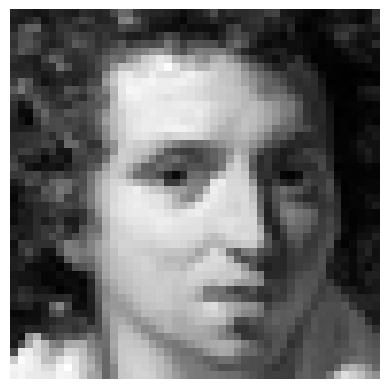

In [25]:
show_image(train_imgs[1000])

## Save numpy arrays

In [67]:
from google.cloud import storage

def save_arrays_to_gcs(imgs, lbls, bucket_name, imgs_filename, lbls_filename):
    """
    Saves the imgs and lbls arrays to Google Cloud Storage (GCS).

    Args:
        imgs (ndarray): NumPy array of training images.
        lbls (ndarray): NumPy array of training labels.
        bucket_name (str): The name of the GCS bucket to store the files.
        imgs_filename (str): The filename for the train_imgs array.
        lbls_filename (str): The filename for the train_lbls array.

    Returns:
        None
    """
    # Set up the GCS client
    client = storage.Client()

    # Save the imgs and lbls arrays to .npy files
    np.save(imgs_filename, imgs)
    np.save(lbls_filename, lbls)

    # Upload the .npy files to the GCS bucket
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(imgs_filename)
    blob.upload_from_filename(imgs_filename)
    blob = bucket.blob(lbls_filename)
    blob.upload_from_filename(lbls_filename)

In [68]:
bucket_name = "msca-ml-final-project"
train_imgs_filename = "train_imgs.npy"
train_lbls_filename = "train_lbls.npy"
test_imgs_filename = "test_imgs.npy"
test_lbls_filename = "test_lbls.npy"
val_imgs_filename = "val_imgs.npy"
val_lbls_filename = "val_lbls.npy"

save_arrays_to_gcs(train_imgs, train_lbls, bucket_name, train_imgs_filename, train_lbls_filename)
save_arrays_to_gcs(test_imgs, test_lbls, bucket_name, test_imgs_filename, test_lbls_filename)
save_arrays_to_gcs(val_imgs, val_lbls, bucket_name, val_imgs_filename, val_lbls_filename)